In [14]:
import os
import json
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

from networks import ConvNetSmall
from advertorch.attacks import GradientSignAttack, LinfPGDAttack

device = "cpu"
ROOT = Path("")

In [26]:
checkpoint_path = os.path.join(ROOT, "/netscratch2/dtaskiran/zoos/CIFAR10/large/tune_zoo_cifar10_large_hyperparameter_10_fixed_seeds")
data_path = os.path.join(ROOT, "/netscratch2/dtaskiran/zoos/CIFAR10/large/tune_zoo_cifar10_large_hyperparameter_10_fixed_seeds/dataset.pt")
data_root = os.path.join(ROOT, "/netscratch2/jlautz/model_robustness/src/model_robustness/data/CIFAR10")

In [27]:
model_list_path = os.path.join(data_root, "PGD", "hyp-10-f")

In [28]:
with open(os.path.join(model_list_path, 'model_list.txt'), "r") as items:
    model_paths = items.readlines()

    for i, l in enumerate(model_paths):
        model_paths[i] = l.replace("\n", "")

In [29]:
dataset = torch.load(data_path)["testset"]

In [50]:
a = dataset[1340][0]
print(a.shape)

torch.Size([3, 32, 32])


In [51]:
dataset[1340][1] # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

tensor(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


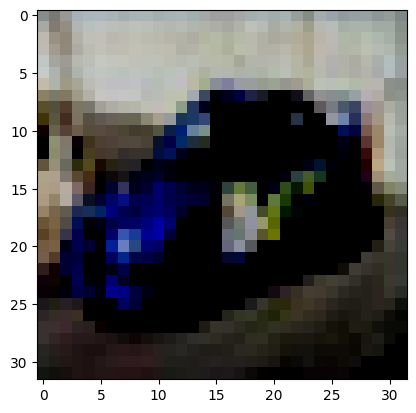

In [52]:
plt.imshow(np.moveaxis(a.detach().cpu().numpy(), 0, 2))

In [15]:
path = model_paths[-1]
    
model_config_path = os.path.join(checkpoint_path, path, "params.json")
config_model = json.load(open(model_config_path, ))

model = ConvNetSmall(
    channels_in=config_model["model::channels_in"],
    nlin=config_model["model::nlin"],
    dropout=config_model["model::dropout"],
    init_type=config_model["model::init_type"]
)
model.load_state_dict(
        torch.load(os.path.join(checkpoint_path, path, "checkpoint_000050", "checkpoints"))
    )
model.to(device)

ConvNetSmall(
  (module_list): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Tanh()
    (3): Conv2d(8, 6, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Tanh()
    (6): Conv2d(6, 4, kernel_size=(2, 2), stride=(1, 1))
    (7): Tanh()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=36, out_features=20, bias=True)
    (10): Tanh()
    (11): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [16]:
aux_loader = DataLoader(dataset=dataset, batch_size=len(dataset), shuffle=False)
for cln_data, true_labels in aux_loader:
    break
cln_data, true_labels = cln_data.to(device), true_labels.to(device)

In [10]:
def calculate_nb_iter(eps_iter):
    return int(np.ceil(min(4+eps_iter, 1.25*eps_iter)))

In [19]:
eps_config = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

In [22]:
acc_list = []
for i, eps_iter in enumerate(eps_config):
    print(eps_iter, ": Starting image generation")
    nb_iter = calculate_nb_iter(eps_iter)
    
    adversary=LinfPGDAttack(
        model,
        loss_fn=nn.CrossEntropyLoss(reduction="sum"),
        eps=1.0,
        nb_iter=nb_iter,
        eps_iter=eps_iter,
        rand_init=True,
        clip_min=0.0,
        clip_max=1.0,
        targeted=False
    )
    adv_images = adversary.perturb(cln_data, true_labels)
    
    perturbed_dataset = TensorDataset(adv_images, true_labels)
    print(eps_iter, ": Images Generated")
    
    loader = DataLoader(dataset=perturbed_dataset, batch_size=10, shuffle=False)
    
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    print(eps_iter, ": Starting Evaluation")
    loss_avg, acc_avg, num_exp = 0, 0, 0
    for j, data in enumerate(loader):

        model.eval()

        imgs, labels = data
        labels = labels.type(torch.LongTensor)
        imgs, labels = imgs.to(device), labels.to(device)
        n_b = labels.shape[0]

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))

        loss_avg += loss.item()
        acc_avg += acc
        num_exp += n_b

    loss_avg /= num_exp
    acc_avg /= num_exp
    print(eps_iter, ": Accuracy = ", acc_avg)
    acc_list.append(acc_avg)
    print(eps_iter, ": Done")

0.0 : Starting image generation
0.0 : Images Generated
0.0 : Starting Evaluation
0.0 : Accuracy =  0.3561
0.0 : Done
0.5 : Starting image generation
0.5 : Images Generated
0.5 : Starting Evaluation
0.5 : Accuracy =  0.0828
0.5 : Done
1.0 : Starting image generation
1.0 : Images Generated
1.0 : Starting Evaluation
1.0 : Accuracy =  0.091
1.0 : Done
1.5 : Starting image generation
1.5 : Images Generated
1.5 : Starting Evaluation


KeyboardInterrupt: 